In [1]:
import numpy as np 
import astropy.units as units
from astropy.units import Quantity
from astropy.time import Time 
import matplotlib
import matplotlib.pyplot as plt 
%matplotlib inline
import cloudpickle
import sys 
sys.path.append("helpers")
import time
import data 
import xo_archive
import fit
import plots

from scipy.stats import norm 
from importlib import reload
import exoplanet as xo 
xo.utils.docs_setup()
import lightkurve as lk 

import pymc3 as pm
import pymc3_ext as pmx
import aesara_theano_fallback.tensor as tt
from celerite2.pymc3 import terms, GaussianProcess
import arviz as az
import corner

matplotlib.rcParams['font.sans-serif'] = ['DejaVu Sans']
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
reload(plots)

<module 'plots' from '/Users/suissa/radius-valley/helpers/plots.py'>

In [2]:
planet_parameters = xo_archive.get_exoplanet_parameters("Kepler-109 ", which="composite")
param_lists = xo_archive.transpose_parameters(planet_parameters)

search_results = lk.search_lightcurve("Kepler-109", mission="Kepler", exptime=1800)
lcc = search_results.download_all()
lc = lcc.stitch().remove_nans()

(0.995, 1.005)

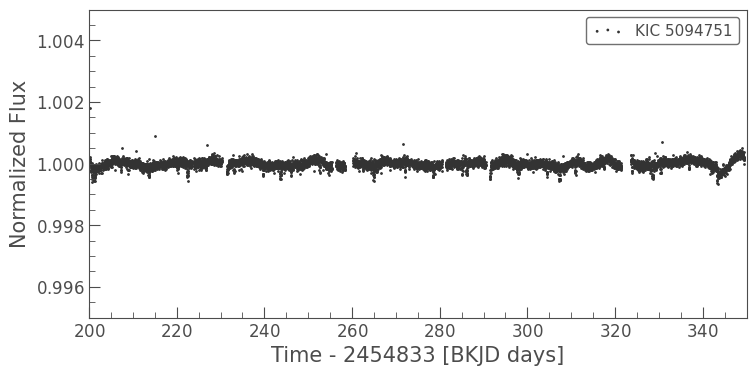

In [3]:
lc.scatter()
plt.xlim(200,350)
plt.ylim(0.995,1.005)

In [4]:
model, difference, std_calculated, mean_tweaked = data.model_data_residuals(param_lists, lc)
lc_final, flags_5sigma = data.remove_outliers(5, lc, difference, std_calculated, mean_tweaked) 

In [5]:
transit_mask = lc_final.create_transit_mask(period=param_lists['pl_orbper']*units.day, 
                                            transit_time=(Time(param_lists["pl_tranmid"],format="jd")), 
                                            duration=param_lists['pl_trandur']*units.hour)

notransits = lc_final[~transit_mask]
transits = lc_final[transit_mask]

In [6]:
transit_windows_mask = fit.create_transit_windows(lc_final, period=param_lists['pl_orbper']*units.day, 
                                            transit_time=(Time(param_lists["pl_tranmid"],format="jd")), 
                                            duration=param_lists['pl_trandur']*units.hour)

transit_windows = lc_final[transit_windows_mask]

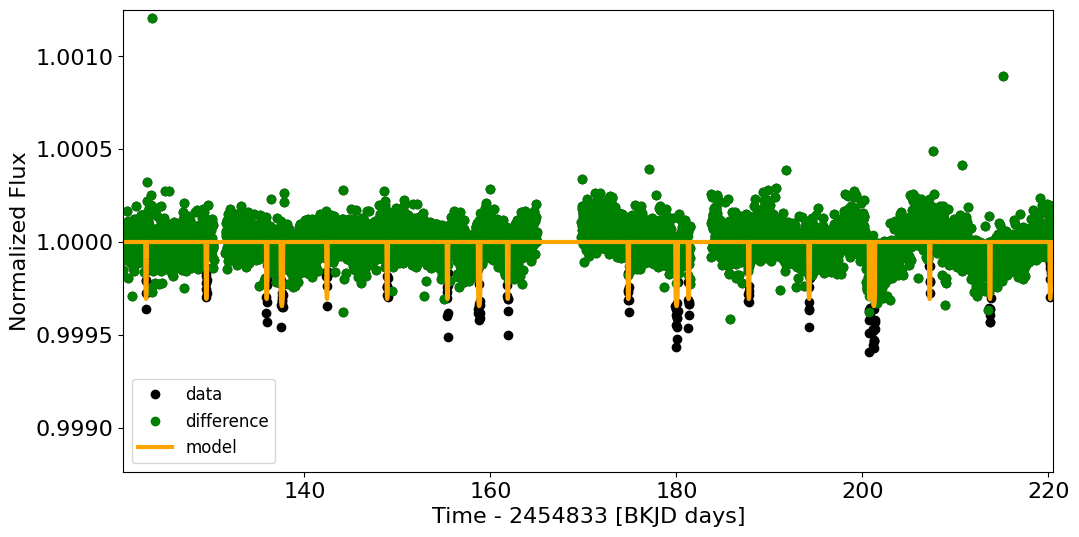

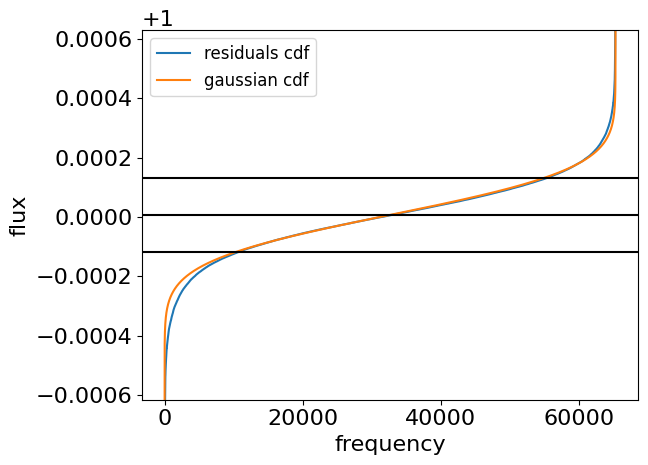

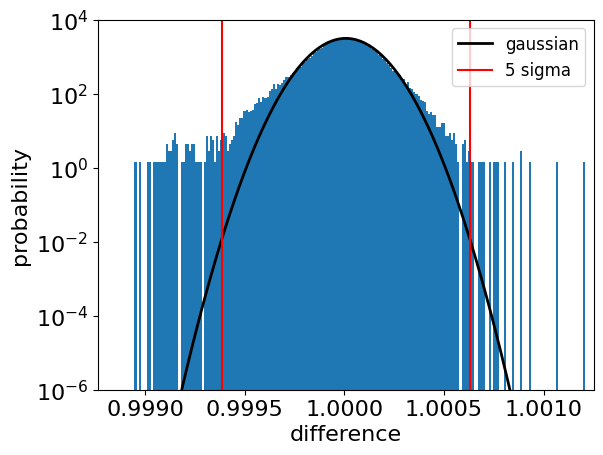

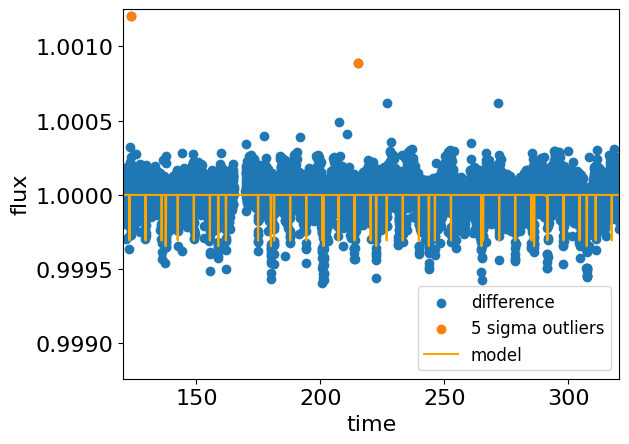

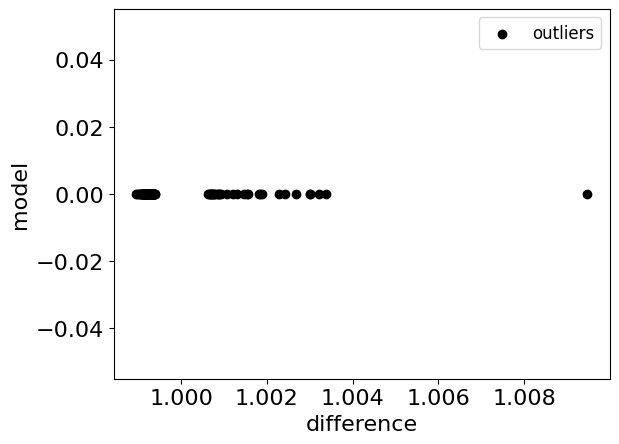

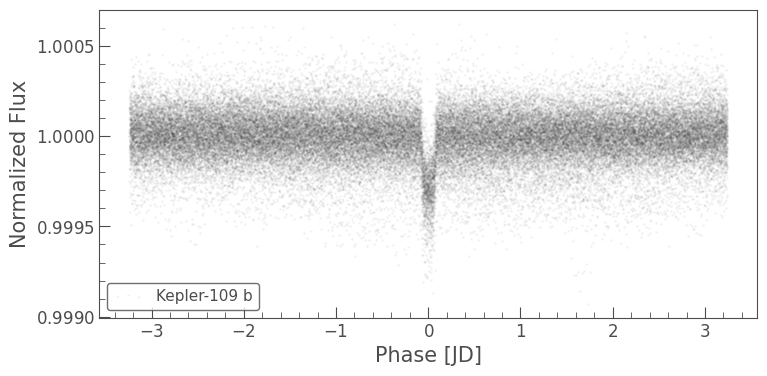

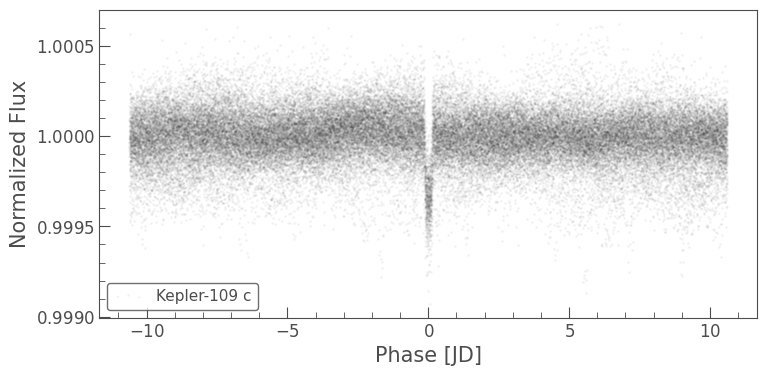

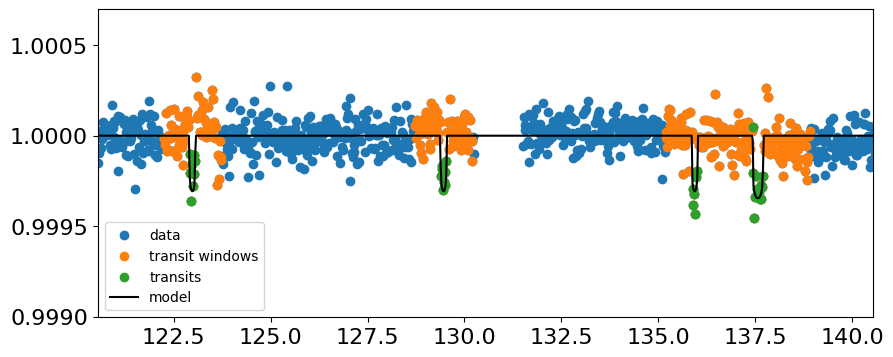

In [7]:
plots.diagnostic_plots(lc, lc_final, transits, transit_windows, param_lists, model, difference, std_calculated, mean_tweaked, sigma=5, flags_nsigma=flags_5sigma)

In [8]:
def gp(lc, complicated_gp=False):

    with pm.Model() as model:

        # Gaussian process 
        if complicated_gp == True: 
            log_jitter = pm.Normal("log_jitter", mu=np.log(np.mean(lc['flux_err'])), sd=1)
            sigma_rot = pm.InverseGamma("sigma_rot", **pmx.estimate_inverse_gamma_parameters(1, 5))
            log_prot = pm.Normal("log_prot", mu=np.log(peak['period']), sd=0.02)
            prot = pm.Deterministic("prot", tt.exp(log_prot))
            log_Q0 = pm.Normal("log_Q0", mu=0, sd=2)
            log_dQ = pm.Normal("log_dQ", mu=0, sd=2)
            f = pm.Uniform("f", lower=0.01, upper=1)
            
            kernel = terms.RotationTerm(sigma=sigma_rot,period=prot,
                                        Q0=tt.exp(log_Q0),dQ=tt.exp(log_dQ),f=f)
            
            gaussian_vars = [log_jitter, sigma_rot, log_prot, log_Q0, log_dQ, f]
                
        else: 
            # A jitter term describing excess white noise
            log_jitter = pm.Normal("log_jitter", mu=np.log(np.mean(lc['flux_err'])), sd=2)
    
            # The standard deviation of the process
            # defined as sqrt(S0 * w0 * Q)
            # where S0 is related to the power when w = 0 
            # and w0 is the undamped angular frequency
            log_sigma_gp = pm.Normal("log_sigma_gp", mu=np.log(np.mean(lc['flux_err'])), sd=10)
        
            # the undamped period of the oscillator
            # 2pi / w0 
            log_rho_gp = pm.Normal("log_rho_gp", mu=0, sd=10) # in days, constrain a little bit 
        
            log_Q0 = pm.Normal("log_Q0", mu=0, sd=2)
    
            # GP model for the light curve
            kernel = terms.SHOTerm(sigma=tt.exp(log_sigma_gp),
                               rho=tt.exp(log_rho_gp),
                               Q=tt.exp(log_Q0))
            
            gaussian_vars = [log_jitter, log_sigma_gp, log_rho_gp, log_Q0]
            
        
        t = np.array(lc['time'].value)
        err = np.array(lc['flux_err'].value)
        gp = GaussianProcess(kernel, 
                             t=t, 
                             diag=lc['flux_err'].value**2 + tt.exp(2*log_jitter), 
                             quiet=False)
        gp.marginal("transit_obs", observed=lc['flux'].value - np.mean(lc['flux'].value))
        pm.Deterministic("gp_pred", gp.predict(lc['flux'].value - np.mean(lc['flux'].value)))
        
        freq = np.linspace(0.01,10,5000)
        pm.Deterministic("psd", kernel.get_psd(freq))
        
        # Optimize the MAP solution
        
        #map_soln = pmx.optimize(start=model.test_point)
    
        start = model.test_point


        map_soln = start
        map_soln = pmx.optimize(start=map_soln, vars=gaussian_vars[:len(gaussian_vars)//2]) 
        map_soln = pmx.optimize(start=map_soln, vars=gaussian_vars[len(gaussian_vars)//2:]) 
        map_soln = pmx.optimize(start=map_soln)
    
    return map_soln

In [9]:
gp_map_soln = gp(notransits)

optimizing logp for variables: [log_sigma_gp, log_jitter]


message: Optimization terminated successfully.
logp: 493472.89944231516 -> 496121.51071602927
optimizing logp for variables: [log_Q0, log_rho_gp]


message: Desired error not necessarily achieved due to precision loss.
logp: 496121.51071602927 -> 499964.39966677007
optimizing logp for variables: [log_Q0, log_rho_gp, log_sigma_gp, log_jitter]


message: Optimization terminated successfully.
logp: 499964.39966677007 -> 500015.0320016394


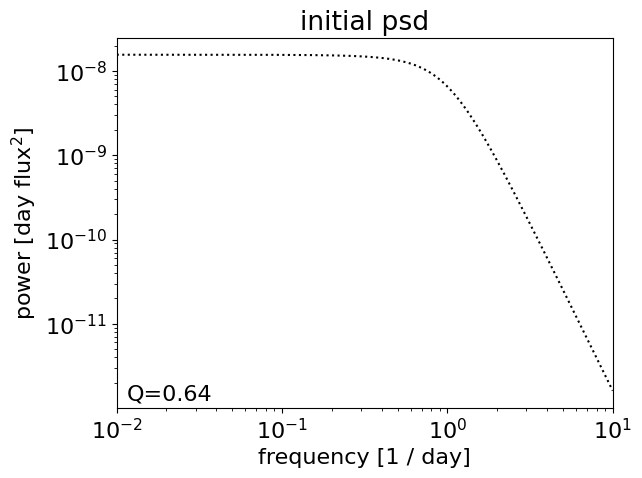

In [10]:
plots.plot_psd(gp_map_soln)

In [11]:
def optimise_model(lc, initial_guesses, gp_map_soln, texp=0.5 / 24, u_init=[0.3, 0.2], start=None, use_mass=False, log_density=True, include_depth=True, log_depth=True, complicated_gp=False):
    """Optimise a transit model to fit some data

    Parameters
    ----------
    lc : :class:`~lightkurve.Lightcurve`
        The lightcurve data
    initial_guesses : `dict`
        Dictionary of initial guesses
    texp : `float`, optional
        Exposure time, by default 0.5/24
    u_init : `list`, optional
        Initial limb darkening guesses, by default [0.3, 0.2]

    Returns
    -------
    model
        PyMC3 model
    map_soln : `dict`
        Dictionary of optimised parameters
    """
    n_planets = len(initial_guesses["pl_orbper"])
    t0s_bkjd = Time(initial_guesses["pl_tranmid"], format="jd").bkjd
    mass_star = np.array(initial_guesses['st_mass'])
    depths = np.array(initial_guesses['pl_trandep'])/100

    with pm.Model() as model:

        # The baseline flux
        mean = pm.Normal("mean", mu=1.0, sd=1.0) 

        # The time of a reference transit for each planet
        t0 = pm.Normal("t0", mu=t0s_bkjd, sd=1.0, shape=n_planets)

        # The log period; also tracking the period itself
        logP = pm.Normal("logP", mu=np.log(initial_guesses["pl_orbper"]), sd=0.1, shape=n_planets)
        period = pm.Deterministic("period", tt.exp(logP))

        # The Kipping (2013) parameterization for quadratic limb darkening parameters
        # An uninformative prior for quadratic limb darkening parameters, flat distribution 
        # u1 (scalar) – The first limb darkening coefficient
        # u2 (scalar) – The second limb darkening coefficient
        u = xo.distributions.QuadLimbDark("u", testval=u_init)
        model_lightcurve = xo.LimbDarkLightCurve(u[0], u[1])
        
        # stellar density 
        initial_dens = initial_guesses["st_dens"][0] if initial_guesses["berger_dens"][0] == -1.0\
            else initial_guesses["berger_dens"][0]
        
        if log_density == True:
            log_rho_star = pm.Normal("log_rho_star",mu=np.log(initial_dens), sd=1)
            rho_star = pm.Deterministic("rho_star", tt.exp(log_rho_star))
            
            system_vars = [log_rho_star]
            
        else: 
            rho_star = pm.Normal("rho_star",mu=initial_dens, sd=1)
            xo.units.with_unit(rho_star, (units.g/(units.cm**3)))
            
            system_vars = [rho_star]
        
        # calculating the stellar radius from density and mass 
        if use_mass == True: 
            r_star = pm.Deterministic("r_star", (((mass_star/rho_star)/((4/3)*np.pi))**(1/3)) * ((units.solMass / (units.g/units.cm**3))**(1/3)).to(units.solRad))
        
        else: 
            r_star = pm.Normal("r_star", mu=initial_guesses["st_rad"][0], sd=10.0)
            
        if include_depth == True:
            
            if log_depth == True: 
                log_depth = pm.Normal("log_depth", mu=np.log(depths), sd=1.0, shape=n_planets)
                depth = pm.Deterministic("depth", tt.exp(log_depth))
                
                system_vars.append(log_depth)
                
            else: 
                depth = pm.Normal("depth", mu=depths, sd=2.0, shape=n_planets)
                
                system_vars.append(depth)
            
            b = pm.Uniform("b", lower=0, upper=1, shape=n_planets, testval=initial_guesses["pl_imppar"])
        
            ror = pm.Deterministic("ror", model_lightcurve.get_ror_from_approx_transit_depth(depth, b))
            
            system_vars.extend([b, t0, mean, logP, r_star, ror, u])
            
        else:
            # the radius ratio between the planet and star 
            ror = pm.Uniform("ror", lower=0.001, upper=0.1, shape=n_planets, testval=initial_guesses["pl_ratror"])
        
            # the impact parameter, uniformly distributed between 0 and 1+ror, where ror is the radius ratio between planet and star
            b = xo.distributions.ImpactParameter("b", ror=ror, shape=n_planets, testval=initial_guesses["pl_imppar"]) 
            
            system_vars.extend([b, t0, mean, logP, r_star, ror, u])
        
        # the radius of the orbiting body, in units of solar radii 
        r_p = pm.Deterministic('r_p', ror*r_star)
        system_vars.append(r_p)

        # Set up a Keplerian orbit for the planets
        orbit = xo.orbits.KeplerianOrbit(period=period, t0=t0, b=b, r_star=r_star, rho_star=rho_star)

        # Compute the model light curve using starry
        light_curves = model_lightcurve.get_light_curve(
            orbit=orbit, r=r_p, t=lc["time"].value, texp=texp*units.day)
        light_curve = tt.sum(light_curves, axis=-1) + mean 

        # Here we track the value of the model light curve for plotting purposes
        pm.Deterministic("light_curves", light_curves) # typo? 
        
        # Gaussian process 
        if complicated_gp == True: 
            log_jitter = gp_map_soln["log_jitter"]
            sigma_rot = gp_map_soln["sigma_rot"]
            log_prot = gp_map_soln["log_prot"]
            prot = gp_map_soln["prot"]
            log_Q0 = gp_map_soln["log_Q0"]
            log_dQ = gp_map_soln["log_dQ"]
            f = gp_map_soln["f"]
            
            kernel = terms.RotationTerm(sigma=sigma_rot,period=prot,
                                        Q0=tt.exp(log_Q0),dQ=tt.exp(log_dQ),f=f)
    
        else: 
            # A jitter term describing excess white noise
            log_jitter = gp_map_soln["log_jitter"]
    
            # The standard deviation of the process
            # defined as sqrt(S0 * w0 * Q)
            # where S0 is related to the power when w = 0 
            # and w0 is the undamped angular frequency
            log_sigma_gp = gp_map_soln["log_sigma_gp"]
        
            # the undamped period of the oscillator
            # 2pi / w0 
            log_rho_gp = gp_map_soln["log_rho_gp"]
        
            log_Q0 = gp_map_soln["log_Q0"]
    
            # GP model for the light curve
            kernel = terms.SHOTerm(sigma=tt.exp(log_sigma_gp),
                               rho=tt.exp(log_rho_gp),
                               Q=tt.exp(log_Q0))
        
        t = np.array(lc['time'].value)
        err = np.array(lc['flux_err'].value)
        gp = GaussianProcess(kernel, 
                             t=t, 
                             diag=lc['flux_err'].value**2 + tt.exp(2*log_jitter), 
                             quiet=True)
        gp.marginal("transit_obs", observed=lc['flux'].value - light_curve)
        pm.Deterministic("gp_pred", gp.predict(lc['flux'].value - light_curve))
        
        # Optimize the MAP solution
            
        if start is None:
            start = model.test_point

        map_soln = start
        map_soln = pmx.optimize(start=map_soln, vars=system_vars[:len(system_vars)//2]) 
        map_soln = pmx.optimize(start=map_soln, vars=system_vars[len(system_vars)//2:]) 
        map_soln = map_soln = pmx.optimize(start=map_soln, vars=[r_p])
        map_soln = pmx.optimize(start=map_soln)
    
    _, mask = plots.plot_fittedlightcurves(lc, initial_guesses, map_soln)
    plots.folded_plots(lc, initial_guesses, map_soln)
    
    return map_soln, model, mask 

optimizing logp for variables: [mean, t0, b, log_depth, log_rho_star]


message: Desired error not necessarily achieved due to precision loss.
logp: 176007.3893423836 -> 176119.8107329295
optimizing logp for variables: [log_depth, __u_q1, __u_q2, b, r_star, logP]


message: Desired error not necessarily achieved due to precision loss.
logp: 176119.8107329295 -> 176121.7423533216
optimizing logp for variables: [log_depth, __u_q1, __u_q2, b, r_star]


message: Desired error not necessarily achieved due to precision loss.
logp: 176121.7423533216 -> 176121.7423533216
optimizing logp for variables: [b, log_depth, r_star, log_rho_star, __u_q2, __u_q1, logP, t0, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: 176121.7423533216 -> 176122.9678825747


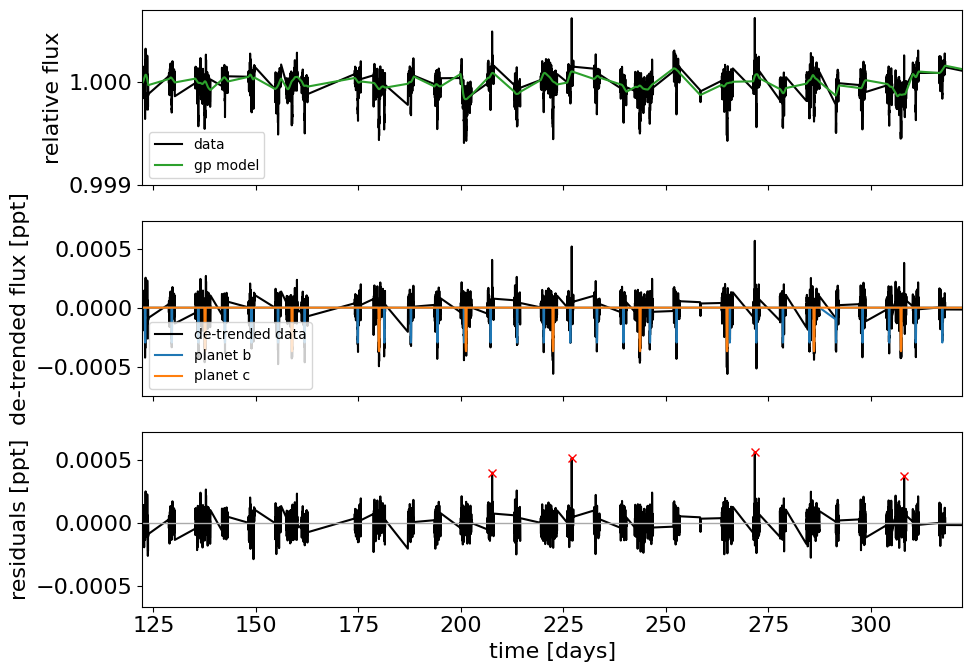

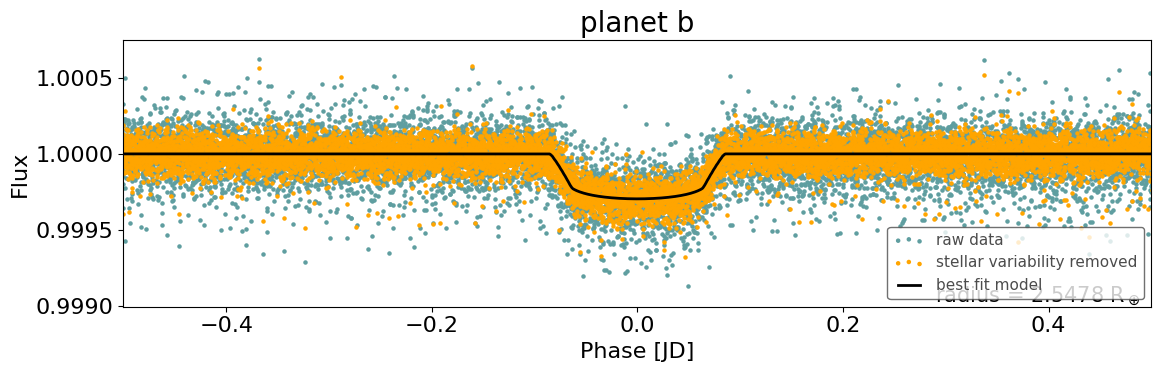

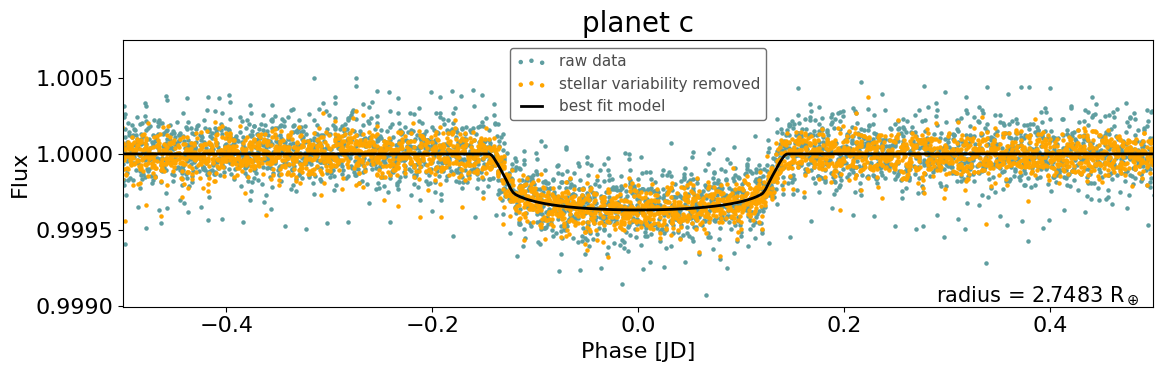

In [12]:
map_soln, model, mask = optimise_model(transit_windows, param_lists, gp_map_soln, use_mass=False, log_density=True, include_depth=True, complicated_gp=False)


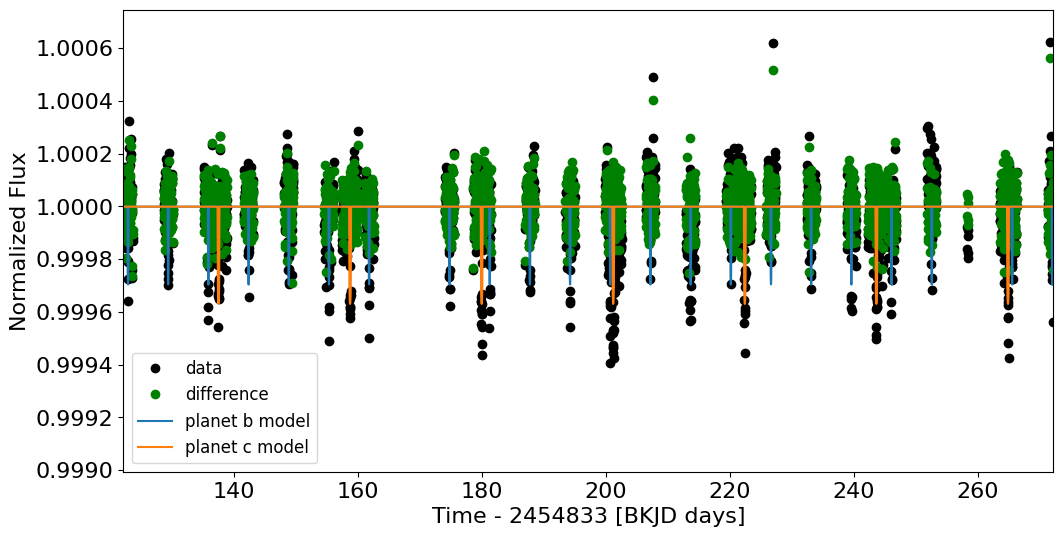

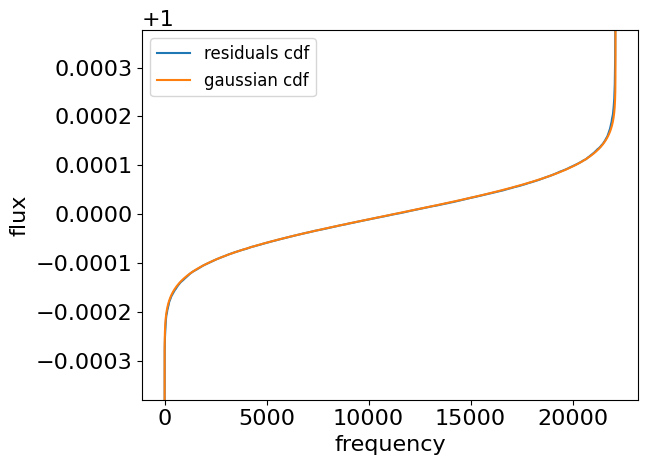

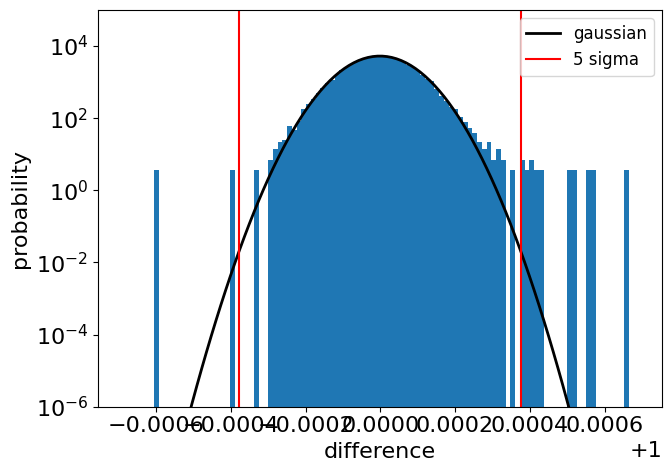

In [13]:
plots.diagnostic_plots_refined(transit_windows, param_lists, map_soln)